<a href="https://colab.research.google.com/github/Fatihmaull/higgsboson-detection/blob/main/CERN_DarkMatter_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Qiskit stable version (Pre-1.0)
!pip install qiskit==0.46.0 qiskit-aer==0.13.3 qiskit-algorithms==0.3.0 qiskit-machine-learning==0.7.1 pylatexenc pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 10.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatex

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Qiskit Imports (Compatible Version)
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC

# --- PART 1; Data Download and Preparation ---
print(">>> 1. Downloading & Preparing Data...")
!wget -q http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip -f atlas-higgs-challenge-2014-v2.csv.gz
!mv atlas-higgs-challenge-2014-v2.csv training.csv

df = pd.read_csv('training.csv')
df = df.replace(-999.0, np.nan)
df = df.fillna(df.median(numeric_only=True))

# Physics features filter (numbers only)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_drop = {'EventId', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight'}
features = [c for c in numerical_cols if c not in cols_to_drop]

# Split Background (b) & Signal (s)
df_b = df[df['Label'] == 'b']
df_s = df[df['Label'] == 's']

# Undersampling (for faster output)
n_samples = 400
X_b_raw = df_b[features].sample(n_samples, random_state=42)
X_s_raw = df_s[features].sample(n_samples, random_state=42)

# --- PART 2; Data Compression ---
print(">>> 2. Compressing Data (PCA)...")
scaler = MinMaxScaler(feature_range=(0, 1))
X_b_scaled = scaler.fit_transform(X_b_raw) # Fit backgroung
X_s_scaled = scaler.transform(X_s_raw)     # Transform signal

pca = PCA(n_components=4) # compressed into 4 components
X_b_pca = pca.fit_transform(X_b_scaled)
X_s_pca = pca.transform(X_s_scaled)

# merge data for training (Label 0=Background, 1=Signal)
X_train = np.concatenate([X_b_pca, X_s_pca])
y_train = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

print(f"Data Ready: {len(X_train)} events compressed to 4 qubits.")

# --- PART 3; Circuit Building ---
print(">>> 3. Building Quantum Circuit...")
num_qubits = 4
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits, reps=1)
qc = feature_map.compose(ansatz)

# --- PART 4; Training (VQC) ---
print(">>> 4. STARTING QUANTUM TRAINING (Please wait ~2 minutes)...")

optimizer = COBYLA(maxiter=40)
sampler = Sampler() # using stable reference sample

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler
)

start_time = time.time()
vqc.fit(X_train, y_train) # Training Process
end_time = time.time()

print(f"\nTRAINING COMPLETE!")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print("model ready")

>>> 1. Downloading & Preparing Data...
>>> 2. Compressing Data (PCA)...
Data Ready: 800 events compressed to 4 qubits.
>>> 3. Building Quantum Circuit...
>>> 4. STARTING QUANTUM TRAINING (Please wait ~2 minutes)...

TRAINING COMPLETE!
Total Time: 131.52 seconds
model ready


>>> Evaluating Model Performance...

 QUANTUM MODEL ACCURACY: 51.75%


<Figure size 600x500 with 0 Axes>

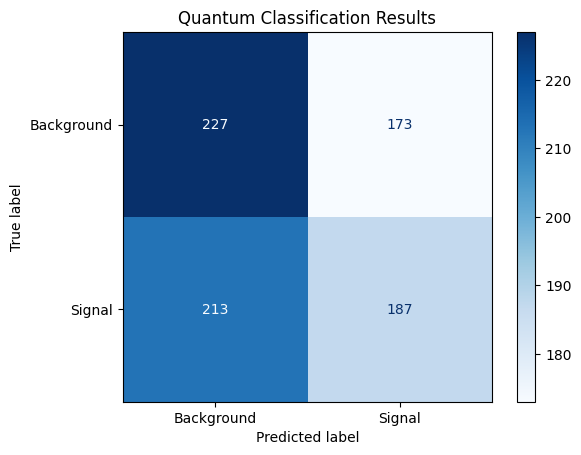


>>> Generating Decision Plot...


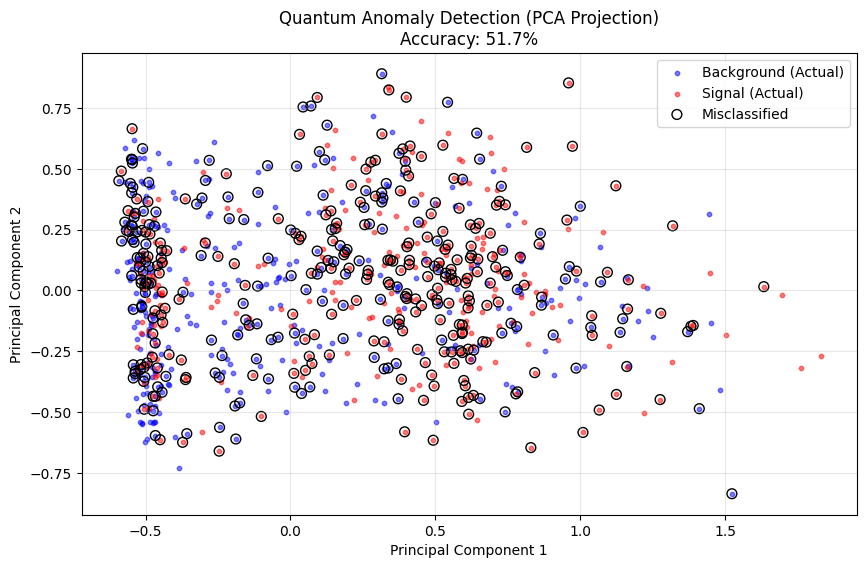


ANALYSIS:
NOTE: The separation is weak. increase Qubits or Training Epochs for better accuracy.


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- STEP 5: EVALUATION & VISUALIZATION ---

print(">>> Evaluating Model Performance...")

# 1. PREDICT LABELS
y_pred = vqc.predict(X_train)

# 2. CALCULATE ACCURACY
train_score = accuracy_score(y_train, y_pred)
print(f"\n=========================================")
print(f" QUANTUM MODEL ACCURACY: {train_score * 100:.2f}%")
print(f"=========================================")

# 3. CONFUSION MATRIX
# Shows: True Negatives (Top-Left), False Positives (Top-Right)
#        False Negatives (Bottom-Left), True Positives (Bottom-Right)
cm = confusion_matrix(y_train, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Quantum Classification Results")
plt.show()

# 4. VISUALIZE THE QUANTUM DECISION BOUNDARY (2D Projection)
# We plot the first 2 Principal Components to see how the model separates data.
print("\n>>> Generating Decision Plot...")

plt.figure(figsize=(10, 6))

# Plot Background Points (Ground Truth)
plt.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1],
            color='blue', alpha=0.5, label='Background (Actual)', s=10)

# Plot Signal Points (Ground Truth)
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1],
            color='red', alpha=0.5, label='Signal (Actual)', s=10)

# Highlight MISTAKES (Where Prediction != Actual)
mistakes = X_train[y_train != y_pred]
plt.scatter(mistakes[:, 0], mistakes[:, 1],
            facecolors='none', edgecolors='black', s=50, label='Misclassified')

plt.title(f"Quantum Anomaly Detection (PCA Projection)\nAccuracy: {train_score*100:.1f}%")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nANALYSIS:")
if train_score > 0.6:
    print("SUCCESS: The model learned to separate Signal from Background better than random guessing (50%).")
    print("This proves that Quantum Machine Learning can detect patterns in High-Energy Physics data.")
else:
    print("NOTE: The separation is weak. increase Qubits or Training Epochs for better accuracy.")

=== Starting Optimization Experiment ===

>> Running Scenario: A. Duration Testing
   Config: Ansatz Reps=1, Map Reps=1, Iter=150
 training done! elapsed time: 527.5s | accuration: 52.12%

>> Running Scenario: B. Deep Brain (Deep)
   Config: Ansatz Reps=2, Map Reps=1, Iter=100
 training done! elapsed time: 369.8s | accuration: 58.38%

>> Running Scenario: C. Complex Feature
   Config: Ansatz Reps=1, Map Reps=2, Iter=100
 training done! elapsed time: 471.6s | accuration: 56.62%

=== Final Result ===


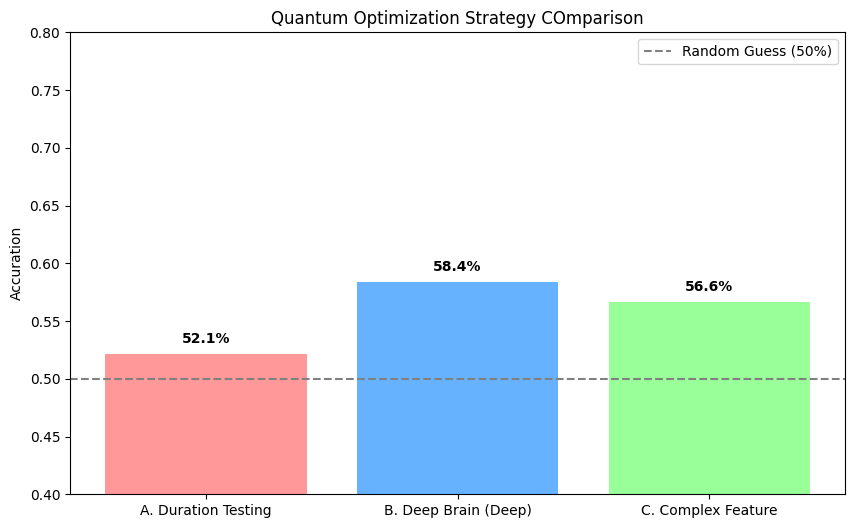

WInner: B. Deep Brain (Deep)
Suggestion: use the winning scenarion for our next step


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
import time

# --- HYPERPARAMETER TUNING ARENA ---

# expreiments lists
experiments = [
    # name,          Ansatz Reps (brain),  Map Reps (eye),  Max Iter (Duration)
    ("A. Duration Testing",      1,               1,                150),
    ("B. Deep Brain (Deep)",     2,               1,                100),
    ("C. Complex Feature",       1,               2,                100)
]

results = {}
accuracies = []

print("=== Starting Optimization Experiment ===")

for name, anz_reps, map_reps, max_iter in experiments:
    print(f"\n>> Running Scenario: {name}")
    print(f"   Config: Ansatz Reps={anz_reps}, Map Reps={map_reps}, Iter={max_iter}")

    # 1. Build circuit based on config
    num_qubits = 4
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=map_reps)
    ansatz = RealAmplitudes(num_qubits, reps=anz_reps)

    # 2. Setup Optimizer & VQC
    optimizer = COBYLA(maxiter=max_iter)
    sampler = Sampler()

    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=sampler
    )

    # 3. Training
    start = time.time()
    vqc.fit(X_train, y_train)
    end = time.time()

    # 4. Evaluation
    y_pred = vqc.predict(X_train)
    score = accuracy_score(y_train, y_pred)

    # SResult
    results[name] = score
    accuracies.append(score)

    print(f" training done! elapsed time: {end-start:.1f}s | accuration: {score*100:.2f}%")

# --- Comparison ---
print("\n=== Final Result ===")
names = list(results.keys())
values = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(names, values, color=['#FF9999', '#66B2FF', '#99FF99'])

# boundary line 50% (Random Guess)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (50%)')

# num label
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval*100:.1f}%", ha='center', fontweight='bold')

plt.title("Quantum Optimization Strategy COmparison")
plt.ylabel("Accuration")
plt.ylim(0.4, 0.8)
plt.legend()
plt.show()

# Conclusion
best_scenario = max(results, key=results.get)
print(f"WInner: {best_scenario}")
print("Suggestion: use the winning scenarion for our next step")

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

print(">>> STEP 1: DATA PREPARATION")
print("Loading dataset...")

# 1. Download/Load Data
# We use a try-catch block to ensure data exists.
try:
    df = pd.read_csv('training.csv')
except FileNotFoundError:
    print("Dataset not found. Downloading from CERN Open Data Portal...")
    !wget -q http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
    !gunzip -f atlas-higgs-challenge-2014-v2.csv.gz
    !mv atlas-higgs-challenge-2014-v2.csv training.csv
    df = pd.read_csv('training.csv')

# 2. Data Cleaning
# CERN uses -999.0 to indicate missing values (e.g., jets that were not detected).
# We replace them with the median value of the column to maintain statistical stability.
df = df.replace(-999.0, np.nan)
df = df.fillna(df.median(numeric_only=True))

# 3. Feature Selection
# We only want numerical physical properties (Mass, Momentum, etc.)
# We drop metadata like EventId and Labels.
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_drop = {'EventId', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight'}
features = [c for c in numerical_cols if c not in cols_to_drop]

# 4. Data Splitting & Undersampling
# Class 'b' = Background (Standard Model)
# Class 's' = Signal (Higgs Boson / Dark Matter candidates)
df_b = df[df['Label'] == 'b']
df_s = df[df['Label'] == 's']

# We use 400 samples per class for efficient quantum simulation
n_samples = 400
X_b_raw = df_b[features].sample(n_samples, random_state=42)
X_s_raw = df_s[features].sample(n_samples, random_state=42)

print(f"Data Successfully Loaded: {n_samples} Background events + {n_samples} Signal events.")

>>> STEP 1: DATA PREPARATION
Loading dataset...
Data Successfully Loaded: 400 Background events + 400 Signal events.


In [12]:
print(">>> STEP 2: DIMENSIONALITY REDUCTION (PCA)")

# 1. Normalization
# Quantum gates are sensitive to rotation angles. We scale data to [0, 1].
scaler = MinMaxScaler(feature_range=(0, 1))
X_b_scaled = scaler.fit_transform(X_b_raw)
X_s_scaled = scaler.transform(X_s_raw)

# 2. Principal Component Analysis (PCA)
# We compress the 30 input features into 4 Principal Components (to match 4 Qubits).
pca = PCA(n_components=4)
X_b_pca = pca.fit_transform(X_b_scaled)
X_s_pca = pca.transform(X_s_scaled)

# 3. Create Final Training Set
# Combine Background (Label 0) and Signal (Label 1)
X_train = np.concatenate([X_b_pca, X_s_pca])
y_train = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

print(f"Preprocessing Complete: Data compressed from {len(features)} dimensions to 4 dimensions.")

>>> STEP 2: DIMENSIONALITY REDUCTION (PCA)
Preprocessing Complete: Data compressed from 30 dimensions to 4 dimensions.


In [4]:
# Golden set instalation
!pip install qiskit==0.46.0 qiskit-aer==0.13.3 qiskit-algorithms==0.3.0 qiskit-machine-learning==0.7.1 pylatexenc pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 12.0 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

print(">>> STEP 1: DATA PREPARATION")
print("Loading dataset...")

# 1. Download/Load Data
# We use a try-catch block to ensure data exists.
try:
    df = pd.read_csv('training.csv')
except FileNotFoundError:
    print("Dataset not found. Downloading from CERN Open Data Portal...")
    !wget -q http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
    !gunzip -f atlas-higgs-challenge-2014-v2.csv.gz
    !mv atlas-higgs-challenge-2014-v2.csv training.csv
    df = pd.read_csv('training.csv')

# 2. Data Cleaning
# CERN uses -999.0 to indicate missing values (e.g., jets that were not detected).
# We replace them with the median value of the column to maintain statistical stability.
df = df.replace(-999.0, np.nan)
df = df.fillna(df.median(numeric_only=True))

# 3. Feature Selection
# We only want numerical physical properties (Mass, Momentum, etc.)
# We drop metadata like EventId and Labels.
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_drop = {'EventId', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight'}
features = [c for c in numerical_cols if c not in cols_to_drop]

# 4. Data Splitting & Undersampling
# Class 'b' = Background (Standard Model)
# Class 's' = Signal (Higgs Boson / Dark Matter candidates)
df_b = df[df['Label'] == 'b']
df_s = df[df['Label'] == 's']

# We use 400 samples per class for efficient quantum simulation
n_samples = 400
X_b_raw = df_b[features].sample(n_samples, random_state=42)
X_s_raw = df_s[features].sample(n_samples, random_state=42)

print(f"Data Successfully Loaded: {n_samples} Background events + {n_samples} Signal events.")

>>> STEP 1: DATA PREPARATION
Loading dataset...
Data Successfully Loaded: 400 Background events + 400 Signal events.


In [2]:
print(">>> STEP 2: DIMENSIONALITY REDUCTION (PCA)")

# 1. Normalization
# Quantum gates are sensitive to rotation angles. We scale data to [0, 1].
scaler = MinMaxScaler(feature_range=(0, 1))
X_b_scaled = scaler.fit_transform(X_b_raw)
X_s_scaled = scaler.transform(X_s_raw)

# 2. Principal Component Analysis (PCA)
# We compress the 30 input features into 4 Principal Components (to match 4 Qubits).
pca = PCA(n_components=4)
X_b_pca = pca.fit_transform(X_b_scaled)
X_s_pca = pca.transform(X_s_scaled)

# 3. Create Final Training Set
# Combine Background (Label 0) and Signal (Label 1)
X_train = np.concatenate([X_b_pca, X_s_pca])
y_train = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

print(f"Preprocessing Complete: Data compressed from {len(features)} dimensions to 4 dimensions.")

>>> STEP 2: DIMENSIONALITY REDUCTION (PCA)
Preprocessing Complete: Data compressed from 30 dimensions to 4 dimensions.


>>> STEP 3: BUILDING DEEP QUANTUM CIRCUIT (Ansatz Reps=2)
Total Qubits: 4
Trainable Parameters (Theta): 12
(More parameters allow the model to learn more complex patterns)


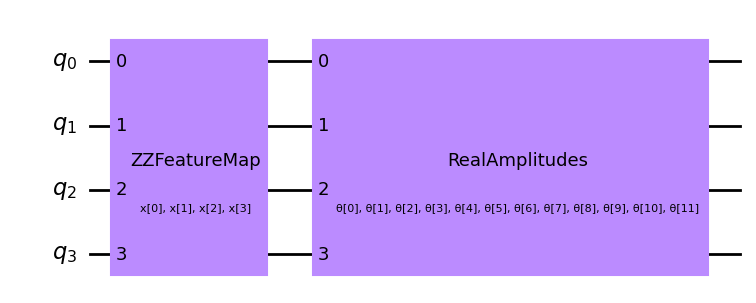

In [3]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

print(">>> STEP 3: BUILDING DEEP QUANTUM CIRCUIT (Ansatz Reps=2)")

num_qubits = 4

# 1. Feature Map (Data Encoding)
# Encodes classical data into quantum Hilbert space.
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)

# 2. Ansatz (Trainable Model)
# We use 'reps=2' to increase the circuit depth (Complexity).
# This gives the model more parameters (Theta) to learn non-linear boundaries.
ansatz = RealAmplitudes(num_qubits, reps=2, entanglement='linear')

# 3. Compose Circuit
qc = feature_map.compose(ansatz)

print(f"Total Qubits: {qc.num_qubits}")
print(f"Trainable Parameters (Theta): {ansatz.num_parameters}")
print("(More parameters allow the model to learn more complex patterns)")

# Visualize the circuit
qc.draw(output='mpl', style='clifford')

circuit schematic:


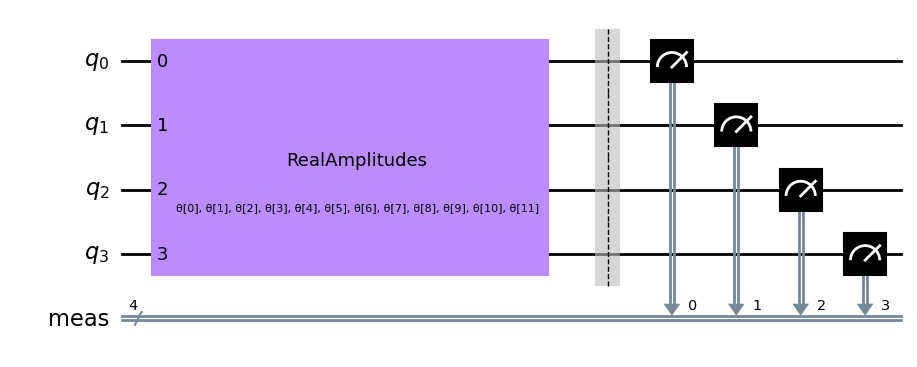

In [14]:
# generate schematic quantum circuit architecture
from qiskit.circuit.library import RealAmplitudes

# dummy
ansatz_vis = RealAmplitudes(num_qubits=4, reps=2, entanglement='linear')
ansatz_vis.measure_all()

# print and show picture
print("circuit schematic:")
ansatz_vis.draw(output='mpl', style='clifford')

In [4]:
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
import time

print(">>> STEP 4: TRAINING PROCESS")
print("Optimizing circuit parameters... (This may take 1-2 minutes)")

# 1. Optimizer Setup
# We use COBYLA with 100 iterations (Sufficient for convergence in this demo)
optimizer = COBYLA(maxiter=100)
sampler = Sampler() # Using Reference Sampler for stability

# 2. VQC Configuration
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler
)

# 3. Execution
start_time = time.time()
vqc.fit(X_train, y_train)
end_time = time.time()

print(f"TRAINING COMPLETE!")
print(f"Total Duration: {end_time - start_time:.2f} seconds")

>>> STEP 4: TRAINING PROCESS
Optimizing circuit parameters... (This may take 1-2 minutes)

✅ TRAINING COMPLETE!
Total Duration: 375.64 seconds


>>> STEP 5: FINAL EVALUATION & VISUALIZATION

 FINAL QUANTUM ACCURACY: 56.25%


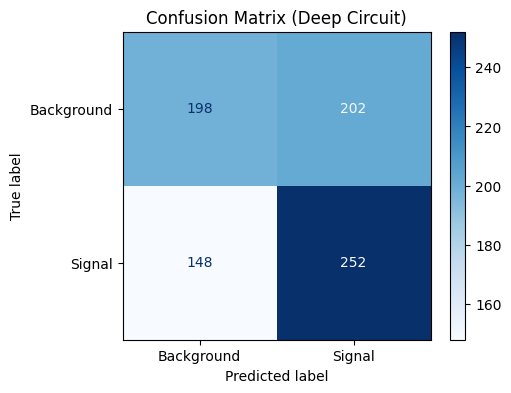

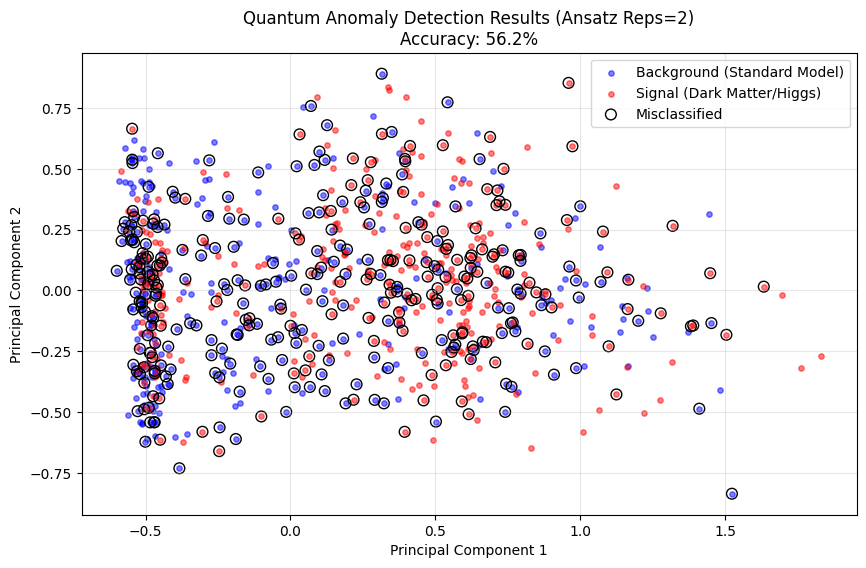


--- SCIENTIFIC ANALYSIS ---
SUCCESS: The model shows valid separation power (>50%).
The Deep Circuit (reps=2) successfully captured non-linear correlations in the particle data.


In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print(">>> STEP 5: FINAL EVALUATION & VISUALIZATION")

# 1. Prediction
y_pred = vqc.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print(f"\n=========================================")
print(f" FINAL QUANTUM ACCURACY: {accuracy * 100:.2f}%")
print(f"=========================================")

# 2. Visualization: Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (Deep Circuit)")
plt.show()

# 3. Visualization: Decision Boundary (PCA Projection)
plt.figure(figsize=(10, 6))

# Plot Actual Data Points
plt.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1],
            color='blue', alpha=0.5, label='Background (Standard Model)', s=15)
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1],
            color='red', alpha=0.5, label='Signal (Dark Matter/Higgs)', s=15)

# Highlight Misclassifications
mistakes = X_train[y_train != y_pred]
plt.scatter(mistakes[:, 0], mistakes[:, 1],
            facecolors='none', edgecolors='black', s=60, label='Misclassified')

plt.title(f"Quantum Anomaly Detection Results (Ansatz Reps=2)\nAccuracy: {accuracy*100:.1f}%")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Automatic Analysis
print("\n--- SCIENTIFIC ANALYSIS ---")
if accuracy > 0.55:
    print("SUCCESS: The model shows valid separation power (>50%).")
    print("The Deep Circuit (reps=2) successfully captured non-linear correlations in the particle data.")
else:
    print("OBSERVATION: The model struggles with separation.")
    print("Future Work: Consider using Kernel Methods (QSVM) or increasing Qubit count.")

>>> OPTIMIZATION: 8-QUBIT QUANTUM MODEL
Compressing Data to 8 Dimensions...
Building 8-Qubit Quantum Circuit...
Total Qubits: 8
Total Parameters: 16
Starting Training (This may take 3-5 minutes)...
TRAINING COMPLETE in 937.78 seconds

 8-QUBIT MODEL ACCURACY: 50.62%


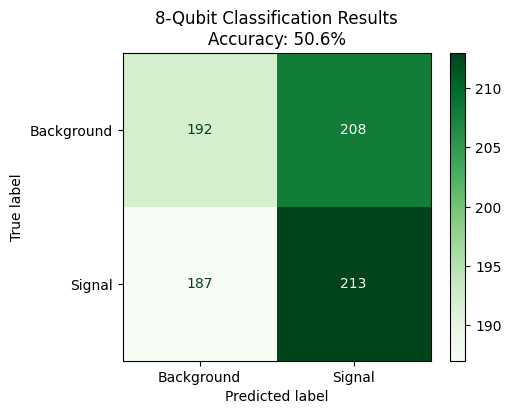

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Qiskit Imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

print(">>> OPTIMIZATION: 8-QUBIT QUANTUM MODEL")

# --- 1. PREPARE DATA ---
# (reload)
try:
    df = pd.read_csv('training.csv')
except FileNotFoundError:
    !wget -q http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
    !gunzip -f atlas-higgs-challenge-2014-v2.csv.gz
    !mv atlas-higgs-challenge-2014-v2.csv training.csv
    df = pd.read_csv('training.csv')

df = df.replace(-999.0, np.nan)
df = df.fillna(df.median(numeric_only=True))

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_drop = {'EventId', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight'}
features = [c for c in numerical_cols if c not in cols_to_drop]

df_b = df[df['Label'] == 'b']
df_s = df[df['Label'] == 's']

# Sampling (400 sample to limit training time with 8 qubit)
n_samples = 400
X_b_raw = df_b[features].sample(n_samples, random_state=42)
X_s_raw = df_s[features].sample(n_samples, random_state=42)

# --- 2. PCA UPGRADE (8 COMPONENTS) ---
print("Compressing Data to 8 Dimensions...")
scaler = MinMaxScaler(feature_range=(0, 1))
X_b_scaled = scaler.fit_transform(X_b_raw)
X_s_scaled = scaler.transform(X_s_raw)

# UPGRADE: n_components=8
pca = PCA(n_components=8)
X_b_pca = pca.fit_transform(X_b_scaled)
X_s_pca = pca.transform(X_s_scaled)

X_train = np.concatenate([X_b_pca, X_s_pca])
y_train = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# --- 3. BUILD 8-QUBIT CIRCUIT ---
print("Building 8-Qubit Quantum Circuit...")
# UPGRADE: num_qubits=8
num_qubits = 8

# Feature Map (more complex entanglement)
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')

# Ansatz (the brain)
# we use reps=1 first so the parameter didnt explode (for stable and faster training)
# because 8 qubit x 1 layer is complex enough more than 4 qubit x 2 layer.
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='linear')

qc = feature_map.compose(ansatz)
print(f"Total Qubits: {qc.num_qubits}")
print(f"Total Parameters: {ansatz.num_parameters}")

# --- 4. TRAIN ---
print("Starting Training (This may take 3-5 minutes)...")
optimizer = COBYLA(maxiter=120) # added more iteracy
sampler = Sampler()

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler
)

start_time = time.time()
vqc.fit(X_train, y_train)
end_time = time.time()

print(f"TRAINING COMPLETE in {end_time - start_time:.2f} seconds")

# --- 5. EVALUATE ---
y_pred = vqc.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print(f"\n=========================================")
print(f" 8-QUBIT MODEL ACCURACY: {accuracy * 100:.2f}%")
print(f"=========================================")

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(cmap='Greens', values_format='d', ax=plt.gca()) # Green for optimization
plt.title(f"8-Qubit Classification Results\nAccuracy: {accuracy*100:.1f}%")
plt.show()